# Example use of the Geoemtry class and optimization tools minimize the width excursion

In this notebook we try to optimize the number of arcs and number of cells per arc to minimize the trajectory excursion and the path length difference. 

**Requirements**

The ```pymoo``` package (https://pymoo.org/), which is pip installable: ```pip install -U pymoo```

** Code structure from D. Amorim code "accelerator_chain_optimization_example_CERN_tunnels.ipynb"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from rcsparameters.chain.chain import RCSChain
from rcsparameters.geometry.geometry import Geometry

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import RankAndCrowding
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.mixed import MixedVariableGA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# Helper function to print the RCS parameters in a table that can be directly pasted in a LaTeX document
from helpers import latex_print_acceleration_attributes, latex_print_rf_attributes

# Increase fontsize in figures
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'figure.titlesize': 'larger'})

In [2]:
# The default RCS chain parameters are recalled here
RCS_name='RCS2'
RCS2_default_para = {  "C": 5990,
   "E_inj": 313.830e9,
   "E_ext": 750e9,
   "LSSS": 2.5,
   "dipole_spacing": 0.4,
   "nb_RF_section": 24,
   "nb_arc": 26,
   "nb_cell_arc": 8,
   "dipoles": {
      "BNC": [1.8, "linear"],
	  "BSC": 10.0
   },
   "filling_ratio": 0.85,
   "filling_ratio_RF": 0.4,
   "pattern": ["BSC","BNC","BSC"]
}

## Example of an optimization

**2 variables**
- the number of arcs per RCS, attribute 'nb_arc' of RCS object
- the number of cells per arc, attribute 'nb_cell_arc' of RCS object

**3 objectives**
- Horizontal excursion in the SC and NC magnet, to be minimized
- Max path length difference, attribute 'max_path_diff' of RCS object, to be minimized

**Inequality constraint**
- the dipole `packing_fraction`, attribute 'filling_ratio_dipole' of RCS object must be below 0.66 or 0.7 for RCS4

**Other assumptions**
- All other parameters are the default ones
- Tunnel lengths and energy stages are to be chosen. See D. Amorim optimization on its code accelerator_chain_optimization_example_CERN_tunnels.ipynb to use CERN tunnel. 


In [8]:
# This class defines the Optimization problem.
# We will specify here the objectives (quantities to minimize, variables to use, constraints)
RCS_default=Geometry(RCS2_default_para, dipole_spacing=0.4)
nc_best=RCS_default.nc_best
nb_RF=RCS_default.nb_RF_section
QP_spacing=RCS_default.QP_dipole_spacing
QP_min=0.40

class MixedVariableProblem(ElementwiseProblem):
    """Optimization problem class

    :type ElementwiseProblem: A pymoo object defining the type of problem we want to solve
    """

    def __init__(self):
        vars = {
                "nb_arc": Integer(bounds=(nb_RF,nb_RF+10)),
                "nb_cell_arc": Integer(bounds=(nc_best//2-1,nc_best+1)),
                # "filling_ratio": Real(bounds=(0.83,0.86))
        }
        super().__init__(vars=vars,
                         n_obj=2,
                         n_ieq_constr=2,
                         n_eq_constr=0,
                         )

        self.default_rcs = Geometry(RCS2_default_para,optimisation=True)

    def _evaluate(self, x, out):

        self.default_rcs.nb_arc = x["nb_arc"]
        self.default_rcs.nb_cell_arc =x["nb_cell_arc"]
        # self.default_rcs.filling_ratio = x["filling_ratio"]

        width=np.max(self.default_rcs.extrema(self.default_rcs.t_ext)[1])-np.min(self.default_rcs.extrema(self.default_rcs.t_inj)[0])
        Dpath=self.default_rcs.max_path_diff

        f_function_list = [width,Dpath]

        #### G are the inequality constraints
        g_constraints_list = []

        if RCS_name == 'RCS4':
            g_constraints_list.append((self.default_rcs.filling_ratio_dipole - 0.7)/0.7)
        else:
            g_constraints_list.append((self.default_rcs.filling_ratio_dipole - 0.66)/0.66)
        g_constraints_list.append(-(self.default_rcs.QP_dipole_spacing-QP_min)/QP_spacing)
        out['F'] = f_function_list
        out['G'] = g_constraints_list

problem = MixedVariableProblem()
algorithm = MixedVariableGA(pop_size=100, survival=RankAndCrowding ())

res = minimize(problem,
               algorithm,
               termination=('n_gen', 20),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       59 |  0.000000E+00 |  2.6225902048 |  0.0594657401 |  0.0266314811
     2 |       77 |  0.000000E+00 |  2.7303651875 |  0.0605841713 |  0.0266314811
     3 |       77 |  0.000000E+00 |  2.7303651875 |  0.0605841713 |  0.0266314811


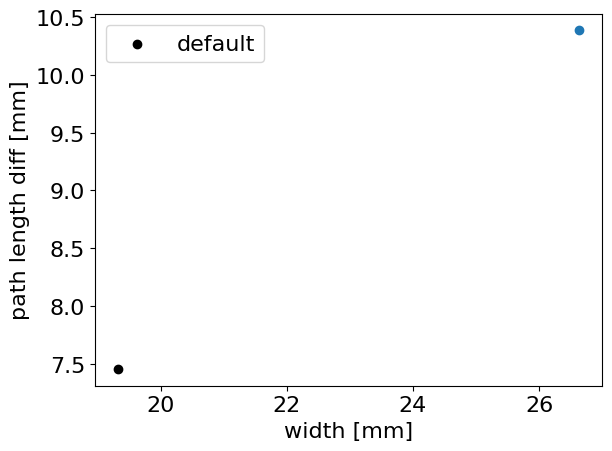

[{'nb_arc': 25, 'nb_cell_arc': 7}] [[0.02663148 0.01038353]]


In [9]:
width_default=np.max(RCS_default.extrema(RCS_default.t_ext)[1])-np.min(RCS_default.extrema(RCS_default.t_inj)[0])
path_default=RCS_default.max_path_diff

plt.figure()
for i in range(len(res.F)):
    plt.scatter(res.F[i][0]*1e3,res.F[i][1]*1e3)
plt.scatter(width_default*1e3,path_default*1e3, color='k',label='default')
plt.xlabel('width [mm]')
plt.ylabel('path length diff [mm]')
plt.legend()
plt.show()
print(res.X,res.F)
# plt.figure()
# for i in range(len(res.X)):
#     plt.scatter(res.X[i]['nb_arc'],res.X[i]['nb_cell_arc'])
# plt.scatter(RCS_default.nb_arc,RCS_default.nb_cell_arc,color='k',label='default')
# plt.xlabel('Number of arcs')
# plt.ylabel('Number of cells per arc')
# plt.legend()
# plt.show()


In [5]:
def print_geo(list_RCS,name):
    print('Geometry')
    print(name)
    print('Number of arcs', [RCS.nb_arc for RCS in list_RCS])
    print('Number of cells per arc',[RCS.nb_cell_arc for RCS in list_RCS])
    print('Filling ratio arc',[RCS.filling_ratio for RCS in list_RCS])
    print('Total arc length [m]', [RCS.tot_arc_length for RCS in list_RCS])
    print('Arc length [m]', [RCS.arc_length for RCS in list_RCS])
    print('Total insertion length [m]', [RCS.tot_insertion_length for RCS in list_RCS])
    print('Insertion length [m]', [RCS.insertion_length for RCS in list_RCS])
    print('Cell length [m]', [RCS.cell_length for RCS in list_RCS])
    print('Total length of dipole', [RCS.dipole_length_tot for RCS in list_RCS])
    print('Dipole filling factor', [RCS.filling_ratio_dipole for RCS in list_RCS])
    print('Dipole spacing', [RCS.dipole_spacing for RCS in list_RCS])
    print('QP-Dipole spacing', [RCS.QP_dipole_spacing for RCS in list_RCS])
    print('Trajectory parameters')
    print('Total trajecory excursion',[np.max(RCS.extrema(RCS.t_ext)[1])-np.min(RCS.extrema(RCS.t_inj)[0]) for RCS in list_RCS])


Geometry
['Default', 'Sol1']
Number of arcs [26, 26]
Number of cells per arc [8, 6]
Filling ratio arc [0.85, 0.85]
Total arc length [m] [5091.5, 5091.5]
Arc length [m] [195.82692307692307, 195.82692307692307]
Total insertion length [m] [898.5, 898.5]
Insertion length [m] [34.55769230769231, 34.55769230769231]
Cell length [m] [24.478365384615383, 32.63782051282051]
Total length of dipole [3654.0676035587517, 3654.0405892020367]
Dipole filling factor [0.6100279805607265, 0.6100234706514251]
Dipole spacing [0.4, 0.4]
QP-Dipole spacing [0.07768316879957693, 0.6536208506377617]
Trajectory parameters
Total trajecory excursion [0.0193239240697594, 0.03303003608453577]
Optimized geometry


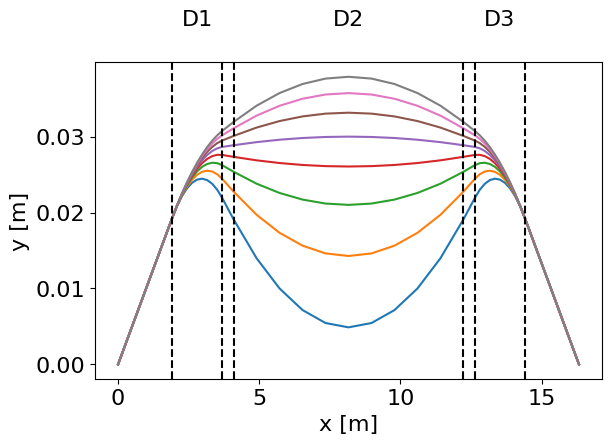

Default geometry


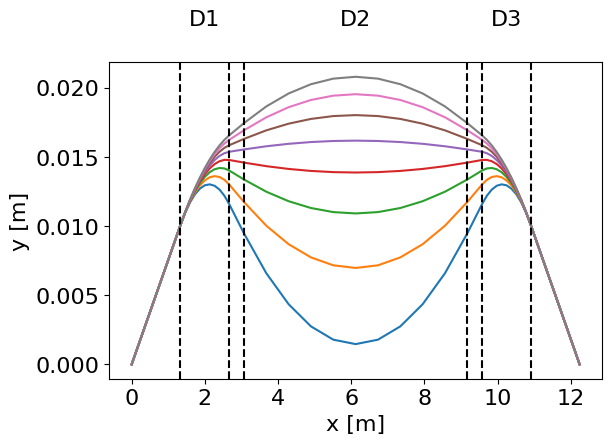

In [6]:
RCS_opt=Geometry(RCS2_default_para,  nb_cell_arc=res.X[0]["nb_cell_arc"]) #,filling_ratio=res.X[0]["filling_ratio"]) nb_arc=res.X[0]["nb_arc"],
# RCS_opt_2=Geometry(RCS2_default_para,nb_arc=res.X[1]["nb_arc"],nb_cell_arc=res.X[1]["nb_cell_arc"])
print_geo([RCS_default,RCS_opt],['Default','Sol1'])
print('Optimized geometry')
RCS_opt.plot_traj(np.linspace(0,1,8))
print('Default geometry')
RCS_default.plot_traj(np.linspace(0,1,8))


We will compare the default chain with this new optimized chain

In [7]:
# # Show the acceleration parameters for the default and the optimized RCS chains
# print('#### Default RCS ####\n')
# latex_table = latex_print_acceleration_attributes(imcc_rcs_chain, rcs_index_to_print=[0,1, 2, 3])
# print(latex_table)

# print('\n\n#### Optimized RCS ####\n')
# latex_table = latex_print_acceleration_attributes(optimized_rcs_chain, rcs_index_to_print=[0,1, 2, 3])
# print(latex_table)